In [25]:
import sys 
import numpy as np 
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
sys.path.append("../models/")
sys.path.append("../simulation/")
from Basin import Basin
from functions import wmape, plot_style
from import_functions import import_projections_deaths, get_averted_deaths

start_date, end_date = datetime(2020, 12, 14), datetime(2021, 10, 1)
colors = plot_style("../fonts/Encode_Sans_Condensed/")

countries =['Sri-Lanka', 'El-Salvador', 'Morocco', 'Bolivia', 'Honduras',
            'Philippines', 'Indonesia', 'Pakistan', 'Rwanda', 'Bangladesh',
            'Kyrgyzstan', 'Egypt', 'Mozambique', 'Afghanistan', 'Angola',
            'Ghana', 'Zambia', "Cote-dIvoire", 'Kenya', 'Uganda']

label_match = {"Cote-dIvoire": "Côte d'Ivoire", 
               "El-Salvador": "El Salvador", 
               "Sri-Lanka": "Sri Lanka"}

for c in countries:
    if c not in label_match.keys():
        label_match[c] = c


def get_deaths_noVaccine(country, scaled=True):
    dates = np.arange(datetime(2020, 12, 14), end_date, timedelta(days=1))
    deaths = import_projections_deaths(country=country, scenario='data-driven', vaccine="False", scaled=scaled,  path="../simulation/projections_october/")

    df_deaths = pd.DataFrame(data={"sim_median": np.median(deaths, axis=0),
                                   "sim_q05": np.quantile(deaths, axis=0, q=0.05), 
                                   "sim_q95": np.quantile(deaths, axis=0, q=0.95)}, index=dates)
    df_deaths = df_deaths.resample("W").sum()
    return df_deaths


def import_fit(country):
    
    sim_deaths = np.load(f"./posteriors/posterior_samples_{country}.npz")["arr_0"]
    basin = Basin(country, "../basins/")
    real_deaths = basin.epi_data_deaths.loc[(basin.epi_data_deaths["date"] >= start_date) &
                                            (basin.epi_data_deaths["date"] < end_date)]

    real_deaths.index = real_deaths.date
    real_deaths = real_deaths.resample("W").sum()

    real_deaths["sim_median"] = np.median(sim_deaths, axis=0)
    real_deaths["sim_q05"] = np.quantile(sim_deaths, axis=0, q=0.05)
    real_deaths["sim_q95"] = np.quantile(sim_deaths, axis=0, q=0.95)

    return real_deaths

../models/functions.py:286: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


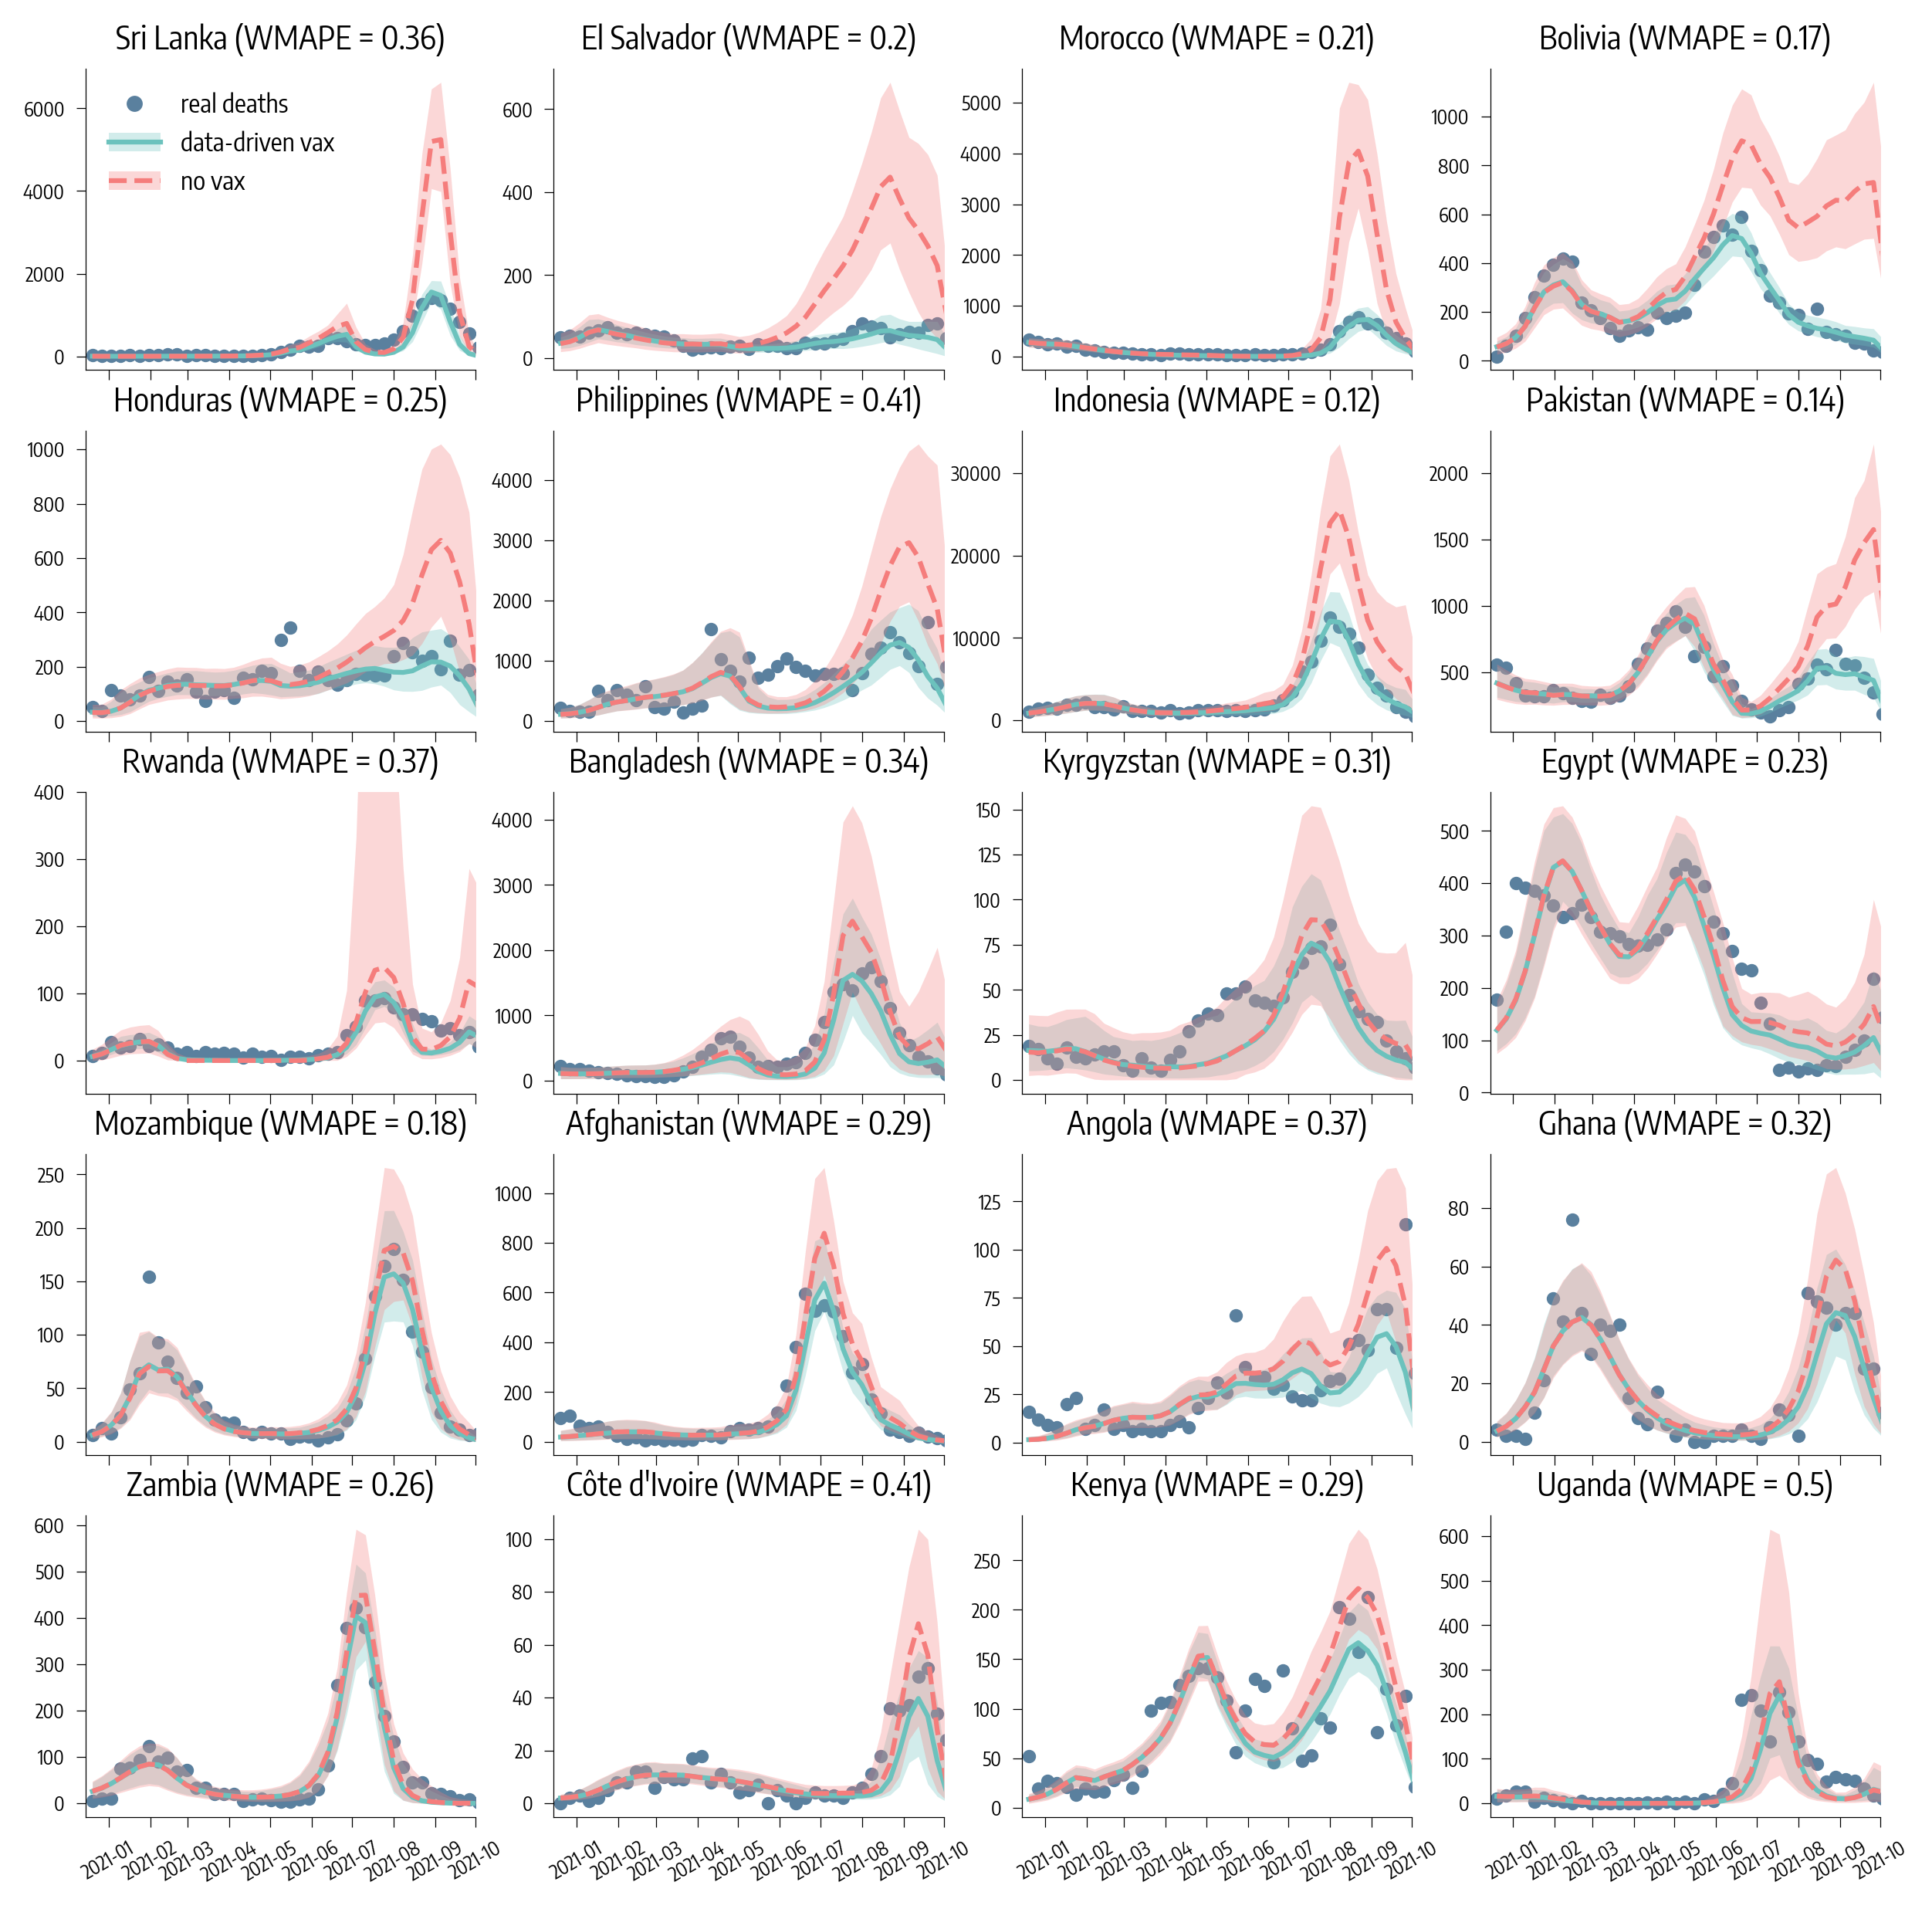

In [23]:
fig, axes = plt.subplots(dpi=300, ncols=4, nrows=5, sharex=True, figsize=(10,10))
for country, ax in zip(countries, axes.ravel()):

    deaths = import_fit(country) 
    deaths_noVaccine = get_deaths_noVaccine(country) 

    ax.scatter(deaths.index, deaths.daily.values, color=colors[1], s=10)
    ax.plot(deaths.index, deaths.sim_median.values, color=colors[0])
    ax.fill_between(deaths.index, deaths.sim_q05.values, deaths.sim_q95.values, color=colors[0], alpha=0.3, linewidth=0)
    ax.plot(deaths_noVaccine.index, deaths_noVaccine.sim_median.values, color=colors[3], linestyle="--")
    ax.fill_between(deaths_noVaccine.index, deaths_noVaccine.sim_q05.values, deaths_noVaccine.sim_q95.values, color=colors[3], alpha=0.3, linewidth=0)

    ax.set_xlim(datetime(2020, 12, 15), end_date)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='x', labelsize=6, rotation=30)
    ax.tick_params(axis='y', labelsize=6)

    wmape_err = wmape(deaths.daily.values, deaths.sim_median.values)
    ax.set_title(label_match[country] + " (WMAPE = " + str(np.round(wmape_err, 2))+ ")", fontsize=10)

    if country == "Rwanda":
        ax.set_ylim(ymax=400)
    
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=6),
                   (Line2D([0], [0], color=colors[0]), Patch(facecolor=colors[0], edgecolor=colors[0], alpha=0.3, linewidth=0)),
                   (Line2D([0], [0], color=colors[3], linestyle='--'), Patch(facecolor=colors[3], edgecolor=colors[3], alpha=0.3, linewidth=0))]


axes[0,0].legend(legend_elements, ['real deaths', 'data-driven vax', 'no vax'], loc='upper left', fontsize=8, frameon=False)
plt.savefig('./img/fit.pdf', bbox_inches="tight")


In [26]:
def import_projections(country, scenario, baseline='data-driven', path="../simulation/projections_october/"):
    # get averted deaths in perc
    avertedDeaths_perc = get_averted_deaths(country, scenario, scaled=False, baseline=baseline, perc=True, path=path)
    avertedDeaths_perc_med = np.median(avertedDeaths_perc)
    return avertedDeaths_perc_med

averted_deaths, percVax = [], []
for country in countries:
    averted_deaths.append(import_projections(country, "data-driven", baseline='False'))
    basin = Basin(country, "../basins/")
    percVax.append(basin.vaccinations.loc[basin.vaccinations.Day == end_date].people_fully_vaccinated_per_hundred.values[0])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


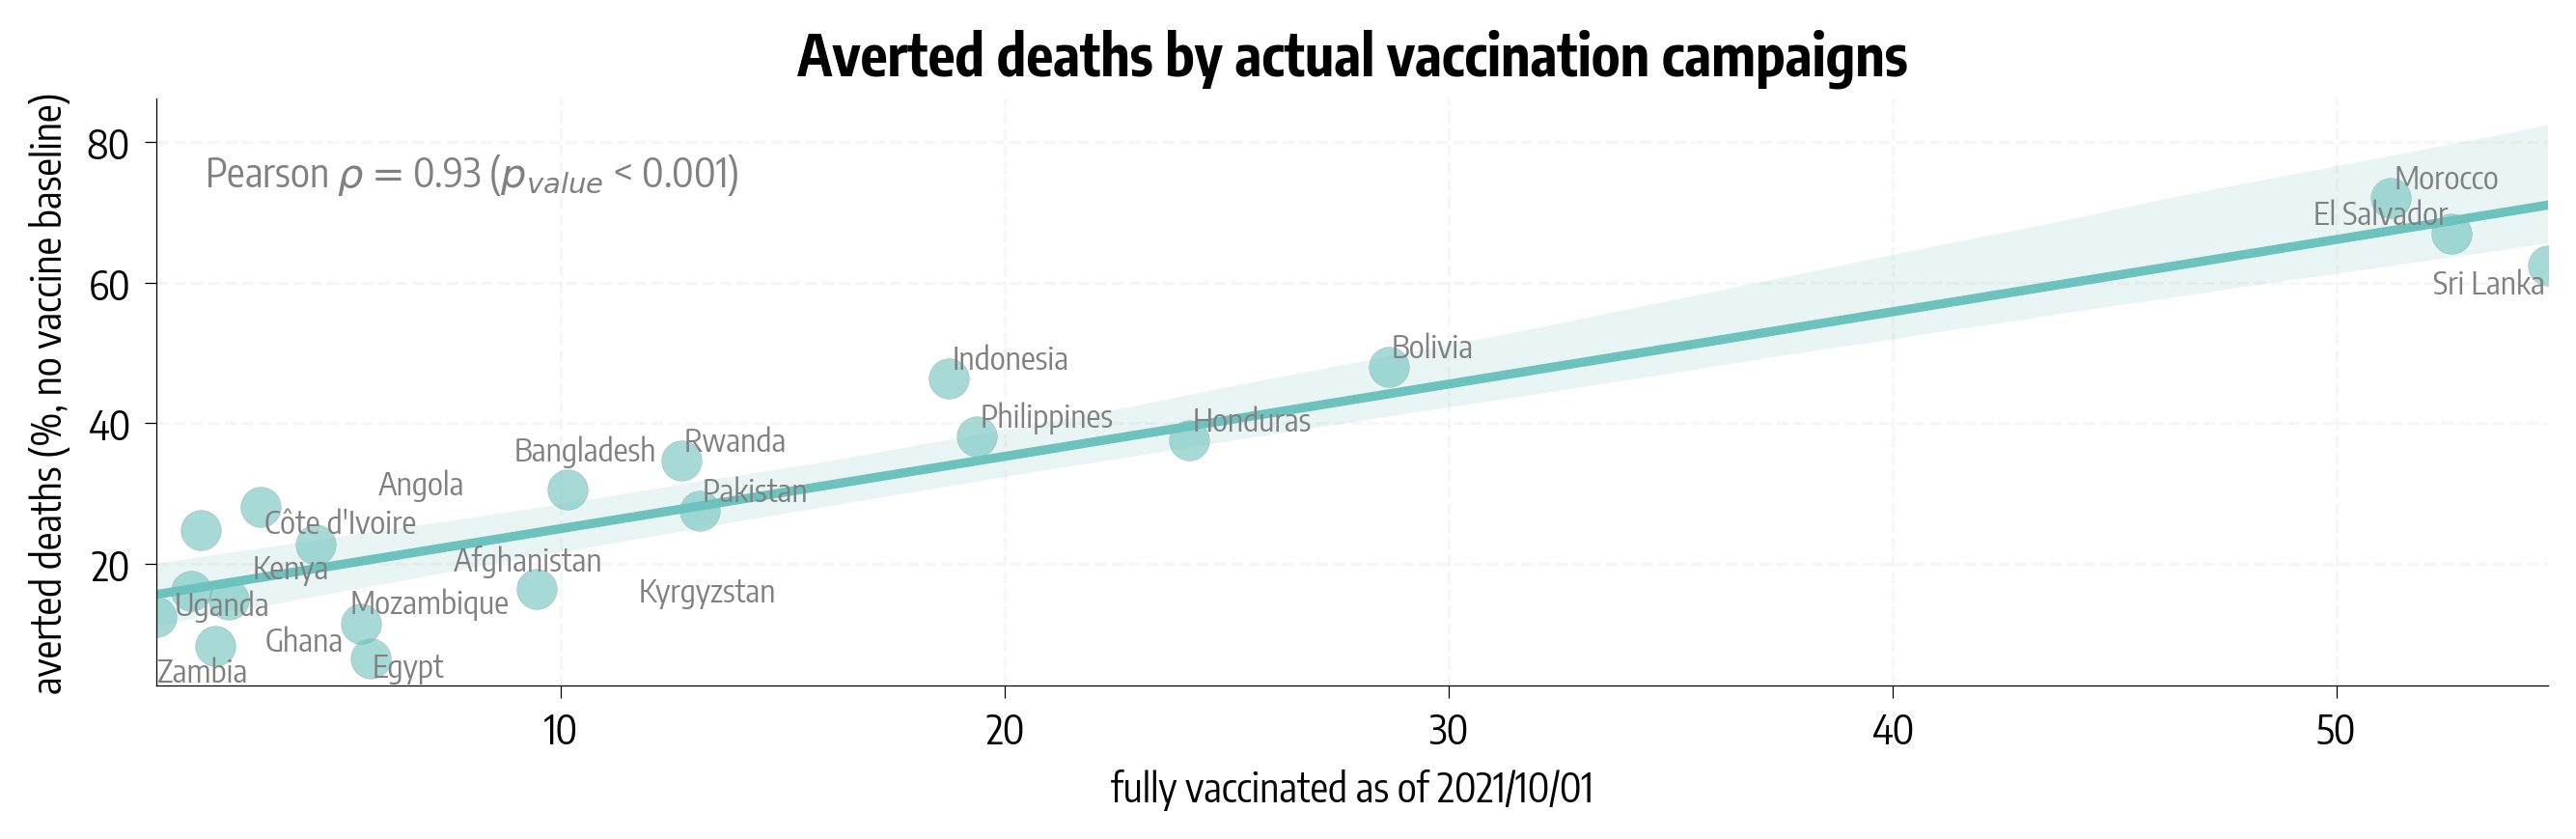

In [27]:
fig, axes = plt.subplot_mosaic([["A", "A", "A"]], dpi=300, figsize=(9, 3))

r, p = pearsonr(averted_deaths, percVax)
sns.regplot(percVax, averted_deaths, color=colors[0], ax=axes["A"], scatter_kws=dict(s=100, alpha=0.6, edgecolor="grey", linewidth=0.1))
axes["A"].set_xlabel("fully vaccinated as of 2021/10/01")
axes["A"].set_ylabel("averted deaths (%, no vaccine baseline)")

texts = []
for i in range(len(countries)):
    weight="normal"
    color="grey"
    texts.append(axes["A"].text(percVax[i], averted_deaths[i], label_match[countries[i]], ha='center', va='center', color=color, fontsize=8, weight=weight))
adjust_text(texts)

axes["A"].set_title("Averted deaths by actual vaccination campaigns", weight="bold", fontsize=14)
axes["A"].spines["top"].set_visible(False)
axes["A"].spines["right"].set_visible(False)
axes["A"].grid(alpha=0.1, linestyle="--")

label = "Pearson $\\rho = $" + str(np.round(r, 2)) + " ($p_{value}$ < 0.001)"
axes["A"].annotate(xy=(0.02, 0.85), xycoords="axes fraction", text=label, color="grey")
plt.tight_layout()

plt.savefig("./img/averted_deaths_actual.pdf", bbox_inches="tight")